# Training a GAN
Training a GAN is simple in principle. You simply use the genertator to create fake images and try to trick the discriminator with them. Each neural net is given a score and they use that to recalculate and adjust their methods. This score is very similar to the loss calculations we did with mnist. The two neural nets push each other to become better and eventually the generator starts to generate fairly realistic images.

In [35]:
%matplotlib inline
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image

from tqdm.notebook import tqdm
import cv2
import os
import matplotlib.pyplot as plt

### Data Sets
We will use a data set to train that we have already downloaded, but if you're willing to install this package it's super easy to download and try your own. This package can work with a website called Kaggle that has large collections of datasets. You will have to make an account, but feel free to go and download your own. Once you find a data set you like, paste the link in the space below and then use your login credentials (a token generated on your profile page) to give the program acess to download it.

In [11]:
#!pip install opendatasets --upgrade --quiet
# import opendatasets as od

# dataset_url= "https://www.kaggle.com/datasets/kimbosoek/cosmos-images"
# od.download(dataset_url)

In [12]:
#setting our variables for training
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [13]:
#load in the training data (use the path to your data set)
DATA_DIR = 'cosmos-images/data'
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle= True, num_workers=3,pin_memory=True)

In [14]:
#some functions for displaying
def denorm(img_tensors):
    return img_tensors*stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize =(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

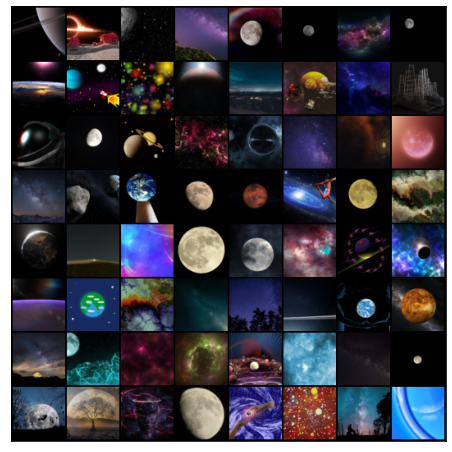

In [15]:
show_batch(train_dl)

### GPU Setup

In [16]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  """Move tensor(s) to chosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
#send our data to the GPU
train_dl = DeviceDataLoader(train_dl,device)

## Create the Discriminator

In [19]:
discriminator = nn.Sequential(
    # in: 3x64x64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 64x32x32
    nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace = True),

    # out: 256x8x8
    nn.Conv2d(128,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256,512, kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 512x4x4

    nn.Conv2d(512,1,kernel_size=4,stride=1, padding =0, bias = False),
    # out: 1x1x1
    nn.Flatten(),
    nn.Sigmoid()
)

In [20]:
#send discriminator to GPU
discriminator = to_device(discriminator,device)

## Create the Generator

In [21]:
latent_size = 128

generator = nn.Sequential(
    # in: lantent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride =1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512x4x4
    
    nn.ConvTranspose2d(512,256, kernel_size=4, stride=2, padding = 1, bias =False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256x8x8

    nn.ConvTranspose2d(256,128, kernel_size=4,stride =2,padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128x16x16

    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64x32x32

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    # out: 3x64x64
)

In [22]:
#send the generator to GPU
generator = to_device(generator,device)

## NN Training Functions

In [23]:
def train_discriminator(real_images,opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1, device=device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size,1,1,device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
     # Clear generator gradients
    opt_g.zero_grad()

    # Generator fake images
    latent = torch.randn(batch_size, latent_size,1,1,device =device)
    fake_images = generator(latent)

    # Try ti fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1, device=device)
    loss = F.binary_cross_entropy(preds,targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [25]:
#create a place to save the images we generate
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

In [26]:
#function for saving our generated images
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir, fake_fname),nrow = 8)
    print('Saving', fake_fname)
    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow = 8).permute(1,2,0))

In [27]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


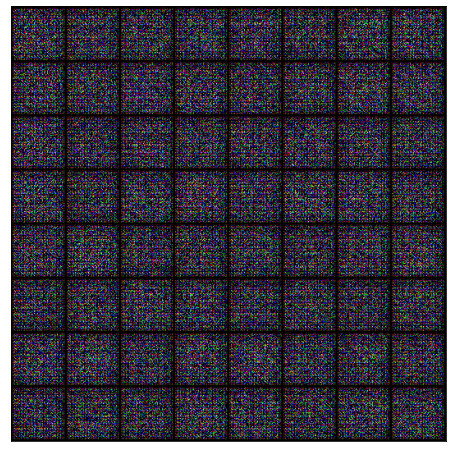

In [28]:
save_samples(0,fixed_latent)

## Training
This is where the actual action happens. The fit function applies the training functions and uses their loss scores accordingly. This function uses the Adam training algorithm we talked about with mnist.

In [29]:
def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    # Create optimize
    opt_d = torch.optim.Adam(discriminator.parameters(),lr = lr, betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images,opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [30]:
#change the epochs to control how many rounds it trains and the loss rate to controll the loss adjustments
lr = 0.0002
epochs = 10

In [31]:
history = fit(epochs, lr)


Epoch [1/10], loss_g: 15.7233, loss_d: 0.0843, real_score: 0.9404, fake_score: 0.0000
Saving generated-images-0001.png



Epoch [2/10], loss_g: 16.7149, loss_d: 0.0046, real_score: 0.9955, fake_score: 0.0000
Saving generated-images-0002.png



Epoch [3/10], loss_g: 5.3979, loss_d: 6.3513, real_score: 0.0040, fake_score: 0.0011
Saving generated-images-0003.png



Epoch [4/10], loss_g: 2.5478, loss_d: 0.4216, real_score: 0.7760, fake_score: 0.1336
Saving generated-images-0004.png



Epoch [5/10], loss_g: 4.3420, loss_d: 0.0705, real_score: 0.9778, fake_score: 0.0456
Saving generated-images-0005.png



Epoch [6/10], loss_g: 4.0472, loss_d: 0.1059, real_score: 0.9230, fake_score: 0.0171
Saving generated-images-0006.png



Epoch [7/10], loss_g: 2.1855, loss_d: 0.8133, real_score: 0.5085, fake_score: 0.0047
Saving generated-images-0007.png



Epoch [8/10], loss_g: 4.8988, loss_d: 0.1046, real_score: 0.9339, fake_score: 0.0297
Saving generated-images-0008.png



Epoch [9/10], loss_g: 3.3525, loss_d: 0.4549, real_score: 0.8480, fake_score: 0.2276
Saving generated-images-0009.png



Epoch [10/10], loss_g: 2.1973, loss_d: 0.3414, real_score: 0.8149, fake_score: 0.1116
Saving generated-images-0010.png


## After Training
Now we can save the models and look at how they worked and the results

In [32]:
losses_g, losses_d, real_scores, fake_scores = history

In [33]:
# Save the model checkpoint
#this will save the models you just trained!
torch.save(generator.state_dict(),'G.pth')
torch.save(discriminator.state_dict(),'D.pth')

In [36]:
vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Text(0.5, 1.0, 'Losses')

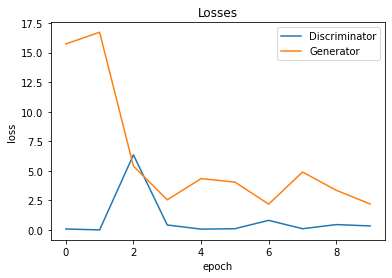

In [37]:
plt.plot(losses_d,'-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

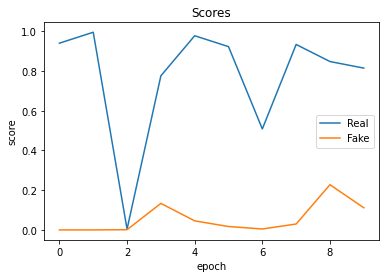

In [38]:
plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real','Fake'])
plt.title('Scores')

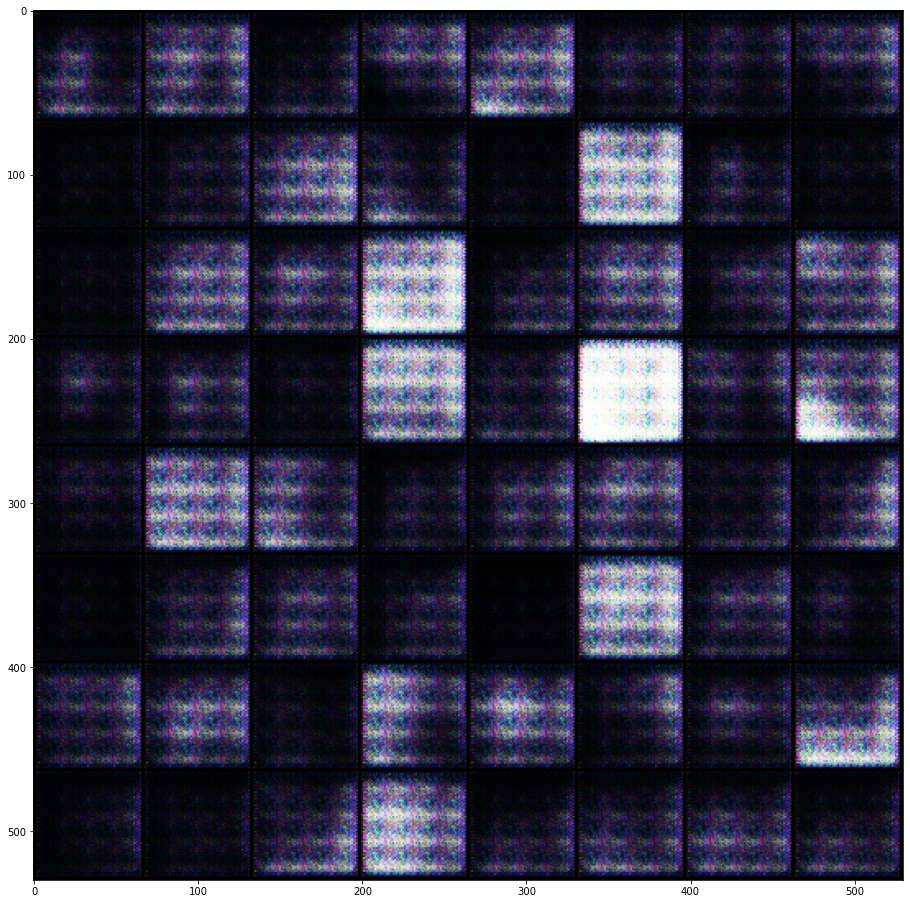

In [39]:
#to see different images change the number it should be formatted like this - you can check the title in the generated folder
I = plt.imread("./generated/generated-images-0005.png")
plt.figure(figsize=(16,16))
plt.imshow(I)